In [60]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pickle
import datetime
import platform
import gala
import astropy
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from sklearn.decomposition import PCA
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import r2_score
import pandas as pd
from scipy.stats import f_oneway
from scipy.fft import rfft, rfftfreq
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from itertools import combinations
from sklearn.metrics import pairwise_distances

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import LinearRegression

from gala.units import galactic
from gala.potential import Hamiltonian
from gala.potential import LogarithmicPotential
from gala.dynamics import PhaseSpacePosition
from gala.dynamics.actionangle import find_actions_o2gf
from gala.dynamics.mockstream import (
    MockStreamGenerator,
    FardalStreamDF
)
from gala.integrate import LeapfrogIntegrator


from tqdm.notebook import tqdm
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
import copy

print(torch.__version__)

/Users/vasu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/vasu/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/vasu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/vasu/anaconda3/lib/python3.11/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/Users/vasu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usag

2.2.2


In [3]:
#import umap.umap_ as umap

In [4]:
import random

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
with open("../data/gc_stream_ensemble.pkl", "rb") as f:
    data = pickle.load(f)

streams = data["streams"]

In [6]:
k = 14
hidden=64

In [7]:
def make_galactic_hamiltonian(q=1.0):
    pot = LogarithmicPotential(
        v_c=220 * u.km/u.s,
        r_h=12 * u.kpc,
        q1=1.0,
        q2=1.0,
        q3=q,
        units=galactic
    )
    return Hamiltonian(pot)

In [8]:
def initial_progenitor_phase_space():
    """
    Initial phase-space position of the progenitor globular cluster.
    """
    pos = [8.5, 0.0, 5.0] * u.kpc
    vel = [0.0, 180.0, 60.0] * u.km/u.s
    return PhaseSpacePosition(pos=pos, vel=vel)

In [9]:
def extract_stream_snapshot(stream_tuple, t_array, time_index=0):

    mock = stream_tuple[0]
    nt = len(t_array)

    total_points = mock.pos.x.shape[0]

    if total_points % nt != 0:
        raise ValueError(
            "Total points not divisible by number of time steps."
        )

    npart = total_points // nt

    # Reshape to (nt, npart)
    x_all = mock.pos.x.reshape(nt, npart)
    y_all = mock.pos.y.reshape(nt, npart)
    z_all = mock.pos.z.reshape(nt, npart)

    vx_all = mock.vel.d_x.reshape(nt, npart)
    vy_all = mock.vel.d_y.reshape(nt, npart)
    vz_all = mock.vel.d_z.reshape(nt, npart)

    # IMPORTANT: Reverse time axis if needed
    # Because stream storage is often reversed relative to t_array
    x_all = x_all[::-1]
    y_all = y_all[::-1]
    z_all = z_all[::-1]

    vx_all = vx_all[::-1]
    vy_all = vy_all[::-1]
    vz_all = vz_all[::-1]

    # Extract requested epoch
    x = x_all[time_index]
    y = y_all[time_index]
    z = z_all[time_index]

    vx = vx_all[time_index]
    vy = vy_all[time_index]
    vz = vz_all[time_index]

    pos = CartesianRepresentation(x, y, z)
    vel = CartesianDifferential(vx, vy, vz)

    pos = pos.with_differentials(vel)

    return PhaseSpacePosition(pos)

In [10]:
def build_stream_graph(stream_snapshot, halo_id, k=k, max_nodes=1500, device="cpu"):
    """
    Build a stream graph from a phase-space snapshot.

    Node features:
        (x, y, z, vx, vy, vz)

    Edge features:
        scalar distance (rotation invariant)

    Parameters
    ----------
    stream_snapshot : gala PhaseSpacePosition
    halo_id : int
    k : int
    max_nodes : int
    device : str
    """

    # -----------------------------------
    # Extract phase-space
    # -----------------------------------
    pos = stream_snapshot.pos.xyz.T.to_value()
    vel = stream_snapshot.vel.d_xyz.T.to_value()

    pos = torch.tensor(pos, dtype=torch.float, device=device)
    vel = torch.tensor(vel, dtype=torch.float, device=device)

    # -----------------------------------
    # Subsample BEFORE graph construction
    # -----------------------------------
    N = pos.size(0)
    if N > max_nodes:
        idx = torch.randperm(N, device=device)[:max_nodes]
        pos = pos[idx]
        vel = vel[idx]

    # -----------------------------------
    # Center positions (translation invariance)
    # -----------------------------------
    pos = pos - pos.mean(dim=0, keepdim=True)

    # -----------------------------------
    # Velocity normalization (per-stream)
    # -----------------------------------
    vel_std = vel.std(dim=0, keepdim=True) + 1e-8
    vel = vel / vel_std

    # -----------------------------------
    # Node features: pure 6D phase-space
    # -----------------------------------
    x = torch.cat([pos, vel], dim=1)   # (N,6)

    # -----------------------------------
    # Build kNN graph
    # -----------------------------------
    N = pos.size(0)
    k = min(k, N - 1)

    with torch.no_grad():
        dist = torch.cdist(pos, pos)
        knn_idx = dist.topk(k=k+1, largest=False).indices[:, 1:]

    row = torch.arange(N, device=device).unsqueeze(1).repeat(1, k).flatten()
    col = knn_idx.flatten()

    edge_index = torch.stack([row, col], dim=0)

    # Edge feature: scalar distance only (rotation invariant)
    edge_attr = dist[row, col].unsqueeze(1)

    graph = Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        halo_id=torch.tensor([halo_id], device=device)
    )

    return graph

In [11]:
# def random_rotation_matrix(device="cpu"):
#     """
#     Generate random rotation matrix about the z-axis only.
#     Preserves halo flattening axis (axisymmetry).

#     Uniform over SO(2).
#     """

#     theta = 2 * torch.pi * torch.rand(1, device=device)

#     cos_t = torch.cos(theta)
#     sin_t = torch.sin(theta)

#     R = torch.tensor([
#         [cos_t, -sin_t, torch.zeros_like(cos_t)],
#         [sin_t,  cos_t, torch.zeros_like(cos_t)],
#         [torch.zeros_like(cos_t),
#          torch.zeros_like(cos_t),
#          torch.ones_like(cos_t)]
#     ], device=device)

#     return R.squeeze().float()

def random_small_rotation(device="cpu", max_angle=0.2):
    """
    Small random rotation around random axis.
    max_angle in radians (~0.3 ≈ 17 degrees)
    """
    axis = torch.randn(3, device=device)
    axis = axis / torch.norm(axis)

    angle = torch.rand(1, device=device) * max_angle

    K = torch.tensor([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ], device=device)

    R = torch.eye(3, device=device) + torch.sin(angle) * K + \
        (1 - torch.cos(angle)) * (K @ K)

    return R


def add_position_noise(pos, noise_fraction=0.005):
    """
    Add small isotropic Gaussian noise scaled to RMS radius.
    """

    rms = torch.sqrt(torch.mean(torch.sum(pos**2, dim=1)))
    scale = noise_fraction * rms

    noise = scale * torch.randn_like(pos)

    return pos + noise


def build_knn_graph(pos, vel, halo_id, k=k):
    """
    Build kNN graph with 6D node features:
        (x, y, z, vx, vy, vz)
    """

    device = pos.device
    N = pos.size(0)
    k = min(k, N - 1)

    # -----------------------------------
    # Node features: (x,y,z,vx,vy,vz)
    # -----------------------------------
    x = torch.cat([pos, vel], dim=1)   # (N,6)

    # -----------------------------------
    # kNN in position space
    # -----------------------------------
    with torch.no_grad():
        dist = torch.cdist(pos, pos)
        knn_idx = dist.topk(k=k+1, largest=False).indices[:, 1:]

    row = torch.arange(N, device=device).unsqueeze(1).repeat(1, k).flatten()
    col = knn_idx.flatten()

    edge_index = torch.stack([row, col], dim=0)

    # Edge features: scalar distance (rotation invariant)
    edge_attr = dist[row, col].unsqueeze(1)

    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        halo_id=halo_id.clone()
    )

def subsample_graph(data, keep_ratio=0.9, k=k):
    """
    Subsample nodes and rebuild graph consistently (6D setup).
    """

    device = data.x.device
    N = data.x.size(0)

    if k is None:
        k = 8

    keep_N = max(16, int(N * keep_ratio))
    keep_N = min(keep_N, N)
    k = min(k, keep_N - 1)

    idx = torch.randperm(N, device=device)[:keep_N]

    pos = data.pos[idx]
    vel = data.x[idx][:, 3:6]   # since x = (x,y,z,vx,vy,vz)

    return build_knn_graph(
        pos=pos,
        vel=vel,
        halo_id=data.halo_id,
        k=k
    )

def augment_graph(data, k=k, keep_ratio=0.9):
    """
    Physics-preserving augmentation:
        - SO(2) rotation
        - Small isotropic position noise
        - Optional subsampling
    """

    device = data.pos.device

    if k is None:
        k = 8

    # -----------------------------------
    # Extract tensors
    # -----------------------------------
    pos = data.pos.clone()
    vel = data.x[:, 3:6].clone()

    # -----------------------------------
    # 1️⃣ Random rotation (SO(2))
    # -----------------------------------
    R = random_small_rotation(device=device, max_angle=0.2)

    pos = pos @ R.T
    vel = vel @ R.T

    # -----------------------------------
    # 2️⃣ Small isotropic noise
    # -----------------------------------
    pos = add_position_noise(pos, noise_fraction=0.003)

    # -----------------------------------
    # 3️⃣ Rebuild graph (NO r anymore)
    # -----------------------------------
    augmented = build_knn_graph(
        pos=pos,
        vel=vel,
        halo_id=data.halo_id,
        k=k
    )

    # -----------------------------------
    # 4️⃣ Optional subsampling
    # -----------------------------------
    if keep_ratio < 1.0:
        augmented = subsample_graph(
            augmented,
            keep_ratio=keep_ratio,
            k=k
        )

    return augmented

In [12]:
halo_mapping = {
    "spherical": 0,
    "oblate": 1,
    "prolate": 2
}

graph_list = []          # For clean evaluation only
stream_metadata = []     # For dynamic training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_time_samples = 6   # evaluation only
stream_id_counter = 0

for s in streams:

    halo_id = halo_mapping[s["halo"]]
    halo_name = s["halo"]

    total_time_steps = len(s["t"])

    # ==========================================
    # Store COMPLETE stream metadata
    # ==========================================
    stream_metadata.append({
        "stream_id": stream_id_counter,
        "stream_object": s["stream"],
        "time_array": s["t"],
        "halo_id": halo_id,
        "halo_name": halo_name,
        "n_time_steps": total_time_steps
    })

    # ==========================================
    # Build CLEAN evaluation graphs (no augmentation)
    # ==========================================
    time_indices = np.linspace(
        0,
        total_time_steps - 1,
        n_time_samples
    ).astype(int)

    for t_idx in time_indices:

        snapshot = extract_stream_snapshot(
            s["stream"],
            s["t"],
            time_index=int(t_idx)
        )

        graph = build_stream_graph(
            snapshot,
            halo_id=halo_id,
            k=k,
            device=device
        )

        # Store identifiers (no gradients, no device complications)
        graph.time_index = torch.tensor(int(t_idx))
        graph.stream_id = torch.tensor(stream_id_counter)
        graph.halo_id = torch.tensor([halo_id])

        graph_list.append(graph)

    stream_id_counter += 1


# ==========================================
# Diagnostics
# ==========================================

print("Total evaluation graphs:", len(graph_list))

halo_counts = Counter([int(g.halo_id.item()) for g in graph_list])
print("Graphs per halo (evaluation):", halo_counts)

print("Total unique streams:", len(stream_metadata))

Total evaluation graphs: 54
Graphs per halo (evaluation): Counter({0: 18, 1: 18, 2: 18})
Total unique streams: 9


In [13]:
graph_list

[Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=0, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=799, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=1599, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=2399, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=3199, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=3999, stream_id=0),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=0, stream_id=1),
 Data(x=[1500, 6], edge_index=[2, 21000], edge_attr=[21000, 1], pos=[1500, 3], halo_id=[1], time_index=799, stream_id=1),
 Data(x=[1500, 6], edge_

In [14]:
# loader = DataLoader(
#     graph_list,
#     batch_size=27,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=torch.cuda.is_available()
# )

In [15]:
g = graph_list[0]

print("Node feature shape:", g.x.shape)
print("Edge index shape:", g.edge_index.shape)
print("Edge attr shape:", g.edge_attr.shape)
print("Halo ID:", g.halo_id)

Node feature shape: torch.Size([1500, 6])
Edge index shape: torch.Size([2, 21000])
Edge attr shape: torch.Size([21000, 1])
Halo ID: tensor([0])


In [16]:
# g1, g2 = generate_contrastive_pair(graph_list[0], k=k)

# print("Augmented 1 nodes:", g1.x.shape)
# print("Augmented 2 nodes:", g2.x.shape)

In [17]:
class EGNNLayer(nn.Module):

    def __init__(self, hidden_dim, dropout=0.05):
        super().__init__()

        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pos, edge_index):

        row, col = edge_index

        # Rotation-invariant squared distance
        rel_pos = pos[row] - pos[col]
        dist2 = torch.sum(rel_pos ** 2, dim=1, keepdim=True)

        # Edge message
        edge_input = torch.cat([x[row], x[col], dist2], dim=1)
        edge_feat = self.edge_mlp(edge_input)

        # Aggregate messages
        agg = torch.zeros(
            x.size(0),
            x.size(1),
            device=x.device
        )
        agg.index_add_(0, row, edge_feat)

        # Node update
        update = self.node_mlp(torch.cat([x, agg], dim=1))
        update = self.dropout(update)

        # Residual + normalization
        x = self.norm(x + update)

        return x


class EGNNEncoder(nn.Module):

    def __init__(self, in_features=6, hidden=hidden, layers=3, emb_dim=24, dropout=0.05):
        super().__init__()

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.LayerNorm(hidden),
            nn.SiLU(),
            nn.Dropout(dropout)
        )

        self.layers = nn.ModuleList([
            EGNNLayer(hidden, dropout=dropout)
            for _ in range(layers)
        ])

        self.lin = nn.Linear(hidden, emb_dim)

    def forward(self, data):

        x, pos, edge_index = data.x, data.pos, data.edge_index
        batch = data.batch

        # Project to hidden space
        x = self.input_proj(x)

        for layer in self.layers:
            x = layer(x, pos, edge_index)

        # Invariant graph pooling
        graph_embedding = global_mean_pool(x, batch)

        z = self.lin(graph_embedding)

        return z

In [18]:
model = EGNNEncoder(in_features=6).to(device)

single_batch = Batch.from_data_list([graph_list[0]]).to(device)

with torch.no_grad():
    test_emb = model(single_batch)

print(test_emb.shape)

torch.Size([1, 24])


In [19]:
# batch = next(iter(loader))
# print(batch)
# print(batch.x.shape)
# print(batch.batch.shape)

In [20]:
def supervised_contrastive_loss(z, labels, tau=0.2):
    """
    Standard Supervised Contrastive Loss
    (Khosla et al., 2020)

    Encourages embeddings of streams from the same halo
    to cluster, while separating different halos.

    Parameters
    ----------
    z : (N, d)
        Graph embeddings
    labels : (N,)
        Halo labels
    tau : float
        Temperature
    """

    z = F.normalize(z, dim=1)
    N = z.size(0)

    sim = torch.matmul(z, z.T) / tau

    # Remove self-similarity
    self_mask = torch.eye(N, device=z.device).bool()
    sim = sim.masked_fill(self_mask, -1e9)

    labels = labels.view(-1, 1)
    positive_mask = (labels == labels.T) & (~self_mask)

    log_prob = sim - torch.logsumexp(sim, dim=1, keepdim=True)

    pos_count = positive_mask.sum(dim=1)
    valid = pos_count > 0

    loss = - (positive_mask * log_prob).sum(dim=1)[valid] / pos_count[valid]

    return loss.mean()


def generate_time_contrastive_batch(
    stream_metadata,
    k=k,
    device="cpu",
    time_samples_per_stream=4
):
    """
    Build a shuffled batch dynamically each epoch.

    - Shuffles stream order
    - Randomly samples time steps
    - Shuffles final graph list before batching
    """

    graphs = []

    # -----------------------------------------
    # 1️⃣ Shuffle stream order
    # -----------------------------------------
    shuffled_streams = np.random.permutation(stream_metadata)

    for meta in shuffled_streams:

        stream = meta["stream_object"]
        time_array = meta["time_array"]
        halo_id = meta["halo_id"]

        total_time_steps = len(time_array)

        # -----------------------------------------
        # 2️⃣ Random time sampling
        # -----------------------------------------
        time_indices = np.random.choice(
            total_time_steps,
            size=time_samples_per_stream,
            replace=False
        )

        for t_idx in time_indices:

            snapshot = extract_stream_snapshot(
                stream,
                time_array,
                time_index=int(t_idx)
            )

            graph = build_stream_graph(
                snapshot,
                halo_id=halo_id,
                k=k,
                device=device
            )

            graphs.append(graph)

    # -----------------------------------------
    # 3️⃣ Shuffle graph order
    # -----------------------------------------
    np.random.shuffle(graphs)

    batch = Batch.from_data_list(graphs).to(device)

    return batch

def build_evaluation_graphs(
    stream_metadata,
    n_eval_times=4,
    k=8,
    device="cpu"
):
    """
    Deterministic evaluation set.
    No augmentation.
    Fixed time slices.
    """

    evaluation_graphs = []

    for meta in stream_metadata:

        stream = meta["stream_object"]
        time_array = meta["time_array"]
        halo_id = meta["halo_id"]

        total_steps = len(time_array)

        eval_indices = np.linspace(
            0,
            total_steps - 1,
            n_eval_times
        ).astype(int)

        for t_idx in eval_indices:

            snapshot = extract_stream_snapshot(
                stream,
                time_array,
                time_index=int(t_idx)
            )

            graph = build_stream_graph(
                snapshot,
                halo_id=halo_id,
                k=k,
                device=device
            )

            evaluation_graphs.append(graph)

    return evaluation_graphs

In [21]:
def halo_prototype_loss(z, labels, temperature=0.07):
    """
    Simple, stable halo clustering loss.

    Steps:
    1. Normalize embeddings
    2. Compute halo centroids
    3. Classify each embedding via distance to centroids
    """

    # Normalize
    z = F.normalize(z, dim=1)

    unique_labels = labels.unique()
    centroids = []

    for h in unique_labels:
        mask = labels == h
        centroids.append(z[mask].mean(dim=0))

    centroids = torch.stack(centroids)  # (H, d)
    centroids = F.normalize(centroids, dim=1)

    # Compute cosine similarity to centroids
    logits = torch.matmul(z, centroids.T) / temperature

    # Map labels to 0..H-1 index
    label_map = {int(h.item()): i for i, h in enumerate(unique_labels)}
    target = torch.tensor(
        [label_map[int(l.item())] for l in labels],
        device=z.device
    )

    loss = F.cross_entropy(logits, target)

    return loss

In [35]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ---------------------------------------------
# Model
# ---------------------------------------------
model = EGNNEncoder(
    in_features=6,
    hidden=hidden,
    layers=3,
    emb_dim=24
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    verbose=True
)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("CUDA:", next(model.parameters()).is_cuda)

# ---------------------------------------------
# Evaluation graphs (clean)
# ---------------------------------------------
evaluation_graph_list = build_evaluation_graphs(
    stream_metadata,
    n_eval_times=n_time_samples,
    k=k,
    device=device
)

print("Evaluation graphs:", len(evaluation_graph_list))

# ---------------------------------------------
# Training hyperparameters
# ---------------------------------------------
epochs = 500
tau = 0.1
#lambda_compact = 0.3

patience = 80
min_epochs = 120
improve_threshold = 5e-4

best_loss = float("inf")
best_epoch = 0
no_improve_counter = 0
best_model_state = None

loss_history = []

start_time = time.time()
print("Starting training...\n")

# ---------------------------------------------
# TRAIN LOOP
# ---------------------------------------------
for epoch in tqdm(range(epochs)):

    # ==============================
    # TRAIN
    # ==============================
    model.train()
    optimizer.zero_grad()

    batch = generate_time_contrastive_batch(
        stream_metadata,
        k=k,
        device=device,
        time_samples_per_stream=4
    )

    labels = batch.halo_id.view(-1)

    z = model(batch)

    #loss = supervised_contrastive_loss(z, labels, tau=tau)
    
    loss = halo_prototype_loss(z, labels, temperature=0.1,) #margin=0.2)
    
    # loss = multi_positive_supervised_contrastive_loss(
    #     z,
    #     labels,
    #     tau=tau
    # )
    
    # loss_comp = halo_compactness_loss(z, labels)

    # loss = loss_sc + 0.5 * loss_comp

    # loss_tuple = halo_contrastive_compact_loss(z, labels, tau=tau, lambda_compact=lambda_compact)
    # loss = loss_tuple[0]

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)

    scheduler.step(loss_val)

    # ==============================
    # SAVE BEST MODEL
    # ==============================
    if loss_val < best_loss - improve_threshold:
        best_loss = loss_val
        best_epoch = epoch
        no_improve_counter = 0

        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, "../models/best_egnn_model.pt")

    else:
        no_improve_counter += 1

    # ==============================
    # EARLY STOPPING
    # ==============================
    if epoch > min_epochs and no_improve_counter >= patience:
        print(f"\nStopping early at epoch {epoch}")
        break

    # ==============================
    # MONITORING
    # ==============================
    if epoch % 10 == 0:

        model.eval()

        with torch.no_grad():

            eval_batch = Batch.from_data_list(
                evaluation_graph_list
            ).to(device)

            z_eval = model(eval_batch)
            z_eval = torch.nn.functional.normalize(z_eval, dim=1)

            z_np = z_eval.cpu().numpy()
            labels_np = eval_batch.halo_id.view(-1).cpu().numpy()

            sil_score = silhouette_score(z_np, labels_np)
            embedding_norm = torch.norm(z_eval, dim=1).mean().item()

        elapsed = time.time() - start_time
        progress = (epoch + 1) / epochs
        eta = elapsed * (1 - progress) / max(progress, 1e-8)

        print(f"\nEpoch {epoch}")
        print(f"Loss: {loss_val:.4f}")
        print(f"Best Loss: {best_loss:.4f} (epoch {best_epoch})")
        print(f"Silhouette (clean eval): {sil_score:.4f}")
        print(f"Embedding norm: {embedding_norm:.4f}")
        print(f"Elapsed: {elapsed:.1f}s | ETA: {eta:.1f}s")
        print("-" * 50)

# ---------------------------------------------
# LOAD BEST MODEL AFTER TRAINING
# ---------------------------------------------
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model from epoch {best_epoch}")
else:
    print("\nNo improvement detected during training.")

total_time = time.time() - start_time

print("\nTraining complete.")
print(f"Best Loss: {best_loss:.4f}")
print(f"Total time: {total_time:.2f} seconds")

Total parameters: 77208
CUDA: False
Evaluation graphs: 54
Starting training...



/Users/vasu/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 0
Loss: 1.0944
Best Loss: 1.0944 (epoch 0)
Silhouette (clean eval): 0.0151
Embedding norm: 1.0000
Elapsed: 7.0s | ETA: 3497.1s
--------------------------------------------------

Epoch 10
Loss: 1.0594
Best Loss: 0.8481 (epoch 6)
Silhouette (clean eval): 0.0945
Embedding norm: 1.0000
Elapsed: 56.0s | ETA: 2489.7s
--------------------------------------------------

Epoch 20
Loss: 0.9838
Best Loss: 0.6583 (epoch 16)
Silhouette (clean eval): 0.1062
Embedding norm: 1.0000
Elapsed: 103.7s | ETA: 2364.5s
--------------------------------------------------

Epoch 30
Loss: 0.9996
Best Loss: 0.5751 (epoch 25)
Silhouette (clean eval): 0.1477
Embedding norm: 1.0000
Elapsed: 151.0s | ETA: 2284.8s
--------------------------------------------------

Epoch 40
Loss: 0.6586
Best Loss: 0.5751 (epoch 25)
Silhouette (clean eval): 0.1428
Embedding norm: 1.0000
Elapsed: 198.1s | ETA: 2218.0s
--------------------------------------------------

Epoch 50
Loss: 0.5240
Best Loss: 0.5240 (epoch 50)
Silhouett

In [44]:
model.eval()

with torch.no_grad():
    batch_all = Batch.from_data_list(graph_list).to(device)
    embeddings = model(batch_all)

embeddings_np = embeddings.cpu().numpy()
embeddings_np = embeddings_np / np.linalg.norm(embeddings_np, axis=1, keepdims=True)

# Correct labels
labels = batch_all.halo_id.view(-1).cpu().numpy()

print("Embeddings shape:", embeddings_np.shape)
print("Labels shape:", labels.shape)

Embeddings shape: (54, 24)
Labels shape: (54,)


In [45]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

accuracies = []

all_y_true = []
all_y_pred = []

for fold, (train_idx, test_idx) in enumerate(skf.split(embeddings_np, labels)):

    X_train = embeddings_np[train_idx]
    y_train = labels_np[train_idx]

    X_test = embeddings_np[test_idx]
    y_test = labels_np[test_idx]

    clf = LogisticRegression(
        max_iter=2000,
         C=0.5,
        solver="lbfgs",
        random_state=42
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Store for confusion matrix
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

print("\nMean Accuracy:", np.mean(accuracies))
print("Std Accuracy :", np.std(accuracies))

Fold 1 Accuracy: 0.7273
Fold 2 Accuracy: 0.7273
Fold 3 Accuracy: 0.8182
Fold 4 Accuracy: 0.9091
Fold 5 Accuracy: 0.5000

Mean Accuracy: 0.7363636363636364
Std Accuracy : 0.13606026860996148


In [54]:
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Spherical", "Oblate", "Prolate"],
    yticklabels=["Spherical", "Oblate", "Prolate"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Linear Probe Confusion Matrix (5-fold CV)")
plt.tight_layout()
# plt.savefig('../figures/Linear Probe Confusion Matrix (5-fold CV)', dpi=140)
# plt.close()

In [47]:
cm

array([[11,  1,  6],
       [ 0, 15,  3],
       [ 4,  0, 14]])

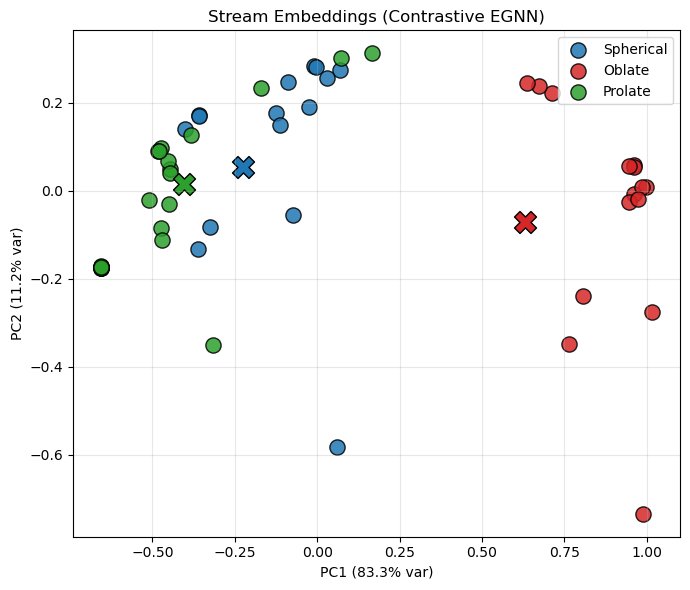

In [48]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)

explained = pca.explained_variance_ratio_

halo_names = {
    0: "Spherical",
    1: "Oblate",
    2: "Prolate"
}

colors = {
    0: "#1f77b4",
    1: "#d62728",
    2: "#2ca02c"
}

plt.figure(figsize=(7,6))

for halo_id in np.unique(labels):

    mask = labels == halo_id

    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        s=120,
        label=halo_names[halo_id],
        color=colors[halo_id],
        edgecolor="k",
        alpha=0.85
    )

    centroid = emb_2d[mask].mean(axis=0)

    plt.scatter(
        centroid[0],
        centroid[1],
        s=250,
        marker="X",
        color=colors[halo_id],
        edgecolor="black"
    )

plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
plt.title("Stream Embeddings (Contrastive EGNN)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

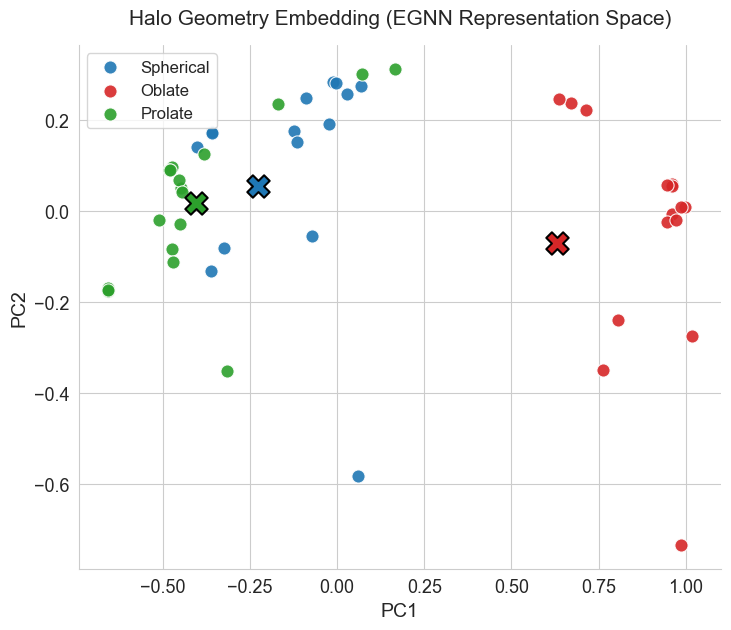

In [76]:
# -----------------------------
# PCA Projection
# -----------------------------
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)
explained = pca.explained_variance_ratio_

# -----------------------------
# Styling
# -----------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 14,
    "legend.fontsize": 12
})

halo_names = {
    0: "Spherical",
    1: "Oblate",
    2: "Prolate"
}

colors = {
    0: "#1f77b4",
    1: "#d62728",
    2: "#2ca02c"
}

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(7.5, 6.5))

for halo_id in np.unique(labels_np):

    mask = labels_np == halo_id

    # Scatter points
    ax.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        s=90,
        color=colors[halo_id],
        edgecolor="white",
        linewidth=0.8,
        alpha=0.9,
        label=halo_names[halo_id]
    )

    # Halo centroid
    centroid = emb_2d[mask].mean(axis=0)

    ax.scatter(
        centroid[0],
        centroid[1],
        s=260,
        marker="X",
        color=colors[halo_id],
        edgecolor="black",
        linewidth=1.5,
        zorder=5
    )

# -----------------------------
# Labels
# -----------------------------
ax.set_xlabel(f"PC1") #({explained[0]*100:.1f}% variance)")
ax.set_ylabel(f"PC2") #({explained[1]*100:.1f}% variance)")
ax.set_title("Halo Geometry Embedding (EGNN Representation Space)", pad=15)

# Cleaner legend
ax.legend(frameon=True, loc="best")

# Remove top/right spines for modern look
sns.despine()

plt.tight_layout()

# High-resolution export (for website)
plt.savefig("halo_embedding_pca.png", dpi=300, bbox_inches="tight")

plt.show()

In [79]:
# PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)
explained = pca.explained_variance_ratio_

sns.set_style("whitegrid")

halo_names = {
    0: "Spherical",
    1: "Oblate",
    2: "Prolate"
}

colors = {
    0: "#1f77b4",
    1: "#d62728",
    2: "#2ca02c"
}

fig, ax = plt.subplots(figsize=(7,6))

for halo_id in np.unique(labels_np):

    mask = labels_np == halo_id
    centroid = emb_2d[mask].mean(axis=0)

    ax.scatter(
        centroid[0],
        centroid[1],
        s=350,
        marker="X",
        color=colors[halo_id],
        edgecolor="black",
        linewidth=1.5,
        label=halo_names[halo_id]
    )

ax.set_xlabel(f"PC1") #({explained[0]*100:.1f}% variance)")
ax.set_ylabel(f"PC2") #({explained[1]*100:.1f}% variance)")
ax.set_title("Halo Geometry Centroids in Representation Space")

ax.legend(frameon=True)
sns.despine()

plt.tight_layout()
# plt.savefig('../figures/Halo Geometry Centroids in Representation Space', dpi=140)
# plt.close()

In [49]:
len(emb_2d[mask, 0])

18

In [50]:
def compute_halo_distance_ratio(model, evaluation_graph_list, device):

    model.eval()

    with torch.no_grad():
        batch = Batch.from_data_list(evaluation_graph_list).to(device)
        z = model(batch)
        z = F.normalize(z, dim=1)

    embeddings = z.cpu().numpy()
    labels = batch.halo_id.view(-1).cpu().numpy()

    # Pairwise Euclidean distances
    D = pairwise_distances(embeddings, metric="euclidean")

    intra_distances = []
    inter_distances = []

    N = len(labels)

    for i in range(N):
        for j in range(i + 1, N):

            if labels[i] == labels[j]:
                intra_distances.append(D[i, j])
            else:
                inter_distances.append(D[i, j])

    intra_mean = np.mean(intra_distances)
    inter_mean = np.mean(inter_distances)

    ratio = inter_mean / (intra_mean + 1e-8)

    return intra_mean, inter_mean, ratio

In [59]:
intra, inter, ratio = compute_halo_distance_ratio(
    model,
    evaluation_graph_list,
    device
)

print("Mean intra-halo distance:", intra)
print("Mean inter-halo distance:", inter)
print("Inter/Intra ratio:", ratio)

Mean intra-halo distance: 0.52683127
Mean inter-halo distance: 0.9189452
Inter/Intra ratio: 1.744287458736543


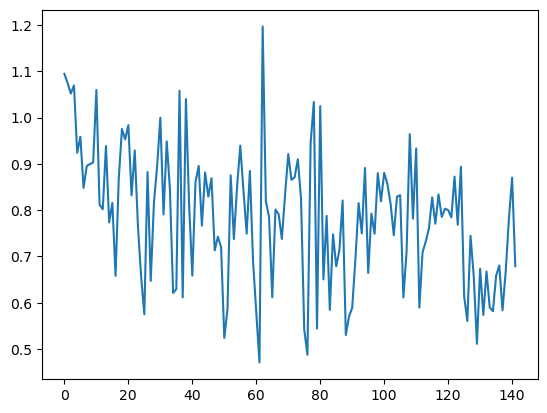

In [52]:
plt.plot(loss_history)

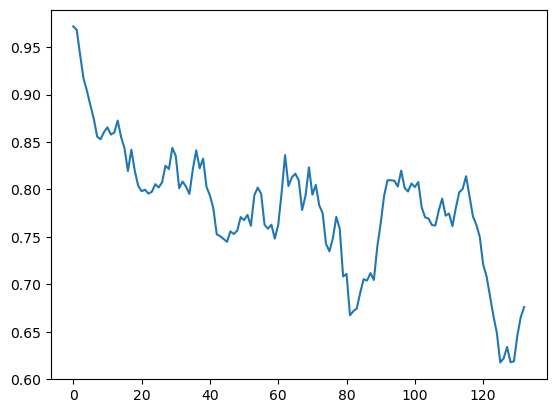

In [53]:
window = 10
smoothed = np.convolve(loss_history, np.ones(window)/window, mode='valid')
plt.plot(smoothed)

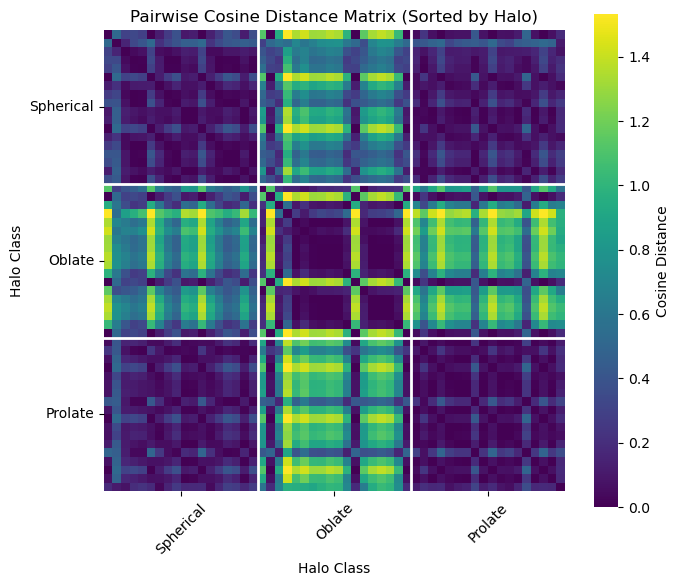

In [74]:
# Compute cosine distance matrix
dist_matrix = cosine_distances(embeddings_np)

# Sort by halo label
sort_idx = np.argsort(labels_np)
sorted_dist = dist_matrix[sort_idx][:, sort_idx]
sorted_labels = labels_np[sort_idx]

# Map numeric labels to halo names
halo_names = {
    0: "Spherical",
    1: "Oblate",
    2: "Prolate"
}

sorted_halo_names = [halo_names[int(l)] for l in sorted_labels]

# Count samples per halo (after sorting)
unique, counts = np.unique(sorted_labels, return_counts=True)
cumulative_counts = np.cumsum(counts)

# -----------------------------------
# Plot heatmap
# -----------------------------------
plt.figure(figsize=(7,6))

ax = sns.heatmap(
    sorted_dist,
    cmap="viridis",
    square=True,
    cbar_kws={"label": "Cosine Distance"}
)

# -----------------------------------
# Add halo boundary lines
# -----------------------------------
for boundary in cumulative_counts[:-1]:
    ax.axhline(boundary, color="white", linewidth=2)
    ax.axvline(boundary, color="white", linewidth=2)

# -----------------------------------
# Add ticks centered in each halo block
# -----------------------------------
block_centers = cumulative_counts - counts / 2

ax.set_xticks(block_centers)
ax.set_yticks(block_centers)

ax.set_xticklabels([halo_names[int(u)] for u in unique], rotation=45)
ax.set_yticklabels([halo_names[int(u)] for u in unique], rotation=0)

plt.title("Pairwise Cosine Distance Matrix (Sorted by Halo)")
plt.xlabel("Halo Class")
plt.ylabel("Halo Class")

plt.tight_layout()
plt.show()

In [58]:
intra = []
inter = []

N = len(labels_np)

for i in range(N):
    for j in range(i+1, N):
        if labels_np[i] == labels_np[j]:
            intra.append(dist_matrix[i,j])
        else:
            inter.append(dist_matrix[i,j])

mean_intra = np.mean(intra)
mean_inter = np.mean(inter)
ratio = mean_inter / mean_intra

print("Mean intra-halo distance:", mean_intra)
print("Mean inter-halo distance:", mean_inter)
print("Inter/Intra ratio:", ratio)

Mean intra-halo distance: 0.22751074
Mean inter-halo distance: 0.5317865
Inter/Intra ratio: 2.3374128
